In [11]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [12]:
import sys
import os

# Add project root to the system path
project_root = os.path.abspath(os.path.join(os.getcwd(), "../../"))
if project_root not in sys.path:
    sys.path.append(project_root)


# Loading experiment parameters

In [13]:
from src.utils.yaml_loader import read_yaml

settings = read_yaml('../../experiments/gridloss/feedforward.yml')
settings

{'dataset_args': {'directory': '/Users/vegardsjavik/Uni/Master/Thesis/BEAST/data/gridloss',
  'training_data': 'train.csv',
  'test_data': 'test.csv',
  'window_size': 168,
  'step_size': 24,
  'timeseries_to_use': ['grid1-load', 'grid1-temp', 'grid1-loss']},
 'forecasting_model_args': {'window_size': 168,
  'network_size': [100, 100],
  'horizon_length': 24,
  'model_name': 'feedforward',
  'model_params_storage_dir': '/Users/vegardsjavik/Uni/Master/Thesis/BEAST/models/feedforward'},
 'training_args': {'batch_size': 16, 'epochs': 100, 'learning_rate': 0.001}}

In [14]:
features_to_use = settings['dataset_args']['timeseries_to_use']
data_dir = os.path.join(settings['dataset_args']['directory'], 'train.csv')
step_size = settings['dataset_args']['step_size']

learning_rate = settings['training_args']['learning_rate']

window_size = settings['forecasting_model_args']['window_size']
horizon_length = settings['forecasting_model_args']['horizon_length']
model_save_dir = settings['forecasting_model_args']['model_params_storage_dir']

input_size = window_size*len(features_to_use)
output_size = horizon_length

# Loading pretrained forecasting model

In [15]:
from src.models.feedforward import NN

model = NN(
    input_size=input_size,
    output_size=output_size,
    save_dir=model_save_dir
)

Loading trained model from /Users/vegardsjavik/Uni/Master/Thesis/BEAST/models/feedforward/feedforward_forecaster.pth...


/Users/vegardsjavik/Uni/Master/Thesis/BEAST/src/models/feedforward.py:36: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



# Loading data

In [16]:
import pandas as pd

df = pd.read_csv(data_dir, index_col=0)
df.index = pd.to_datetime(df.index)
df = df[features_to_use]
df = df.bfill()
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17520 entries, 2017-12-01 00:00:00 to 2019-11-30 23:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   grid1-load  17520 non-null  float64
 1   grid1-temp  17520 non-null  float64
 2   grid1-loss  17520 non-null  float64
dtypes: float64(3)
memory usage: 547.5 KB


## Creating windows of dataset

In [17]:
from src.utils.generate_dataset import generate_windows_dataset

num_ts = len(features_to_use)
dataset_size = (df.shape[0] - window_size)//step_size + 1

data = generate_windows_dataset(df, window_size, step_size, features_to_use)

100%|██████████| 724/724 [00:00<00:00, 103995.76it/s]


## Calculate features

In [18]:
from src.utils.features import decomp_and_features
import numpy as np

sp = 24 # STL parameter

decomps, features = decomp_and_features(data, series_periodicity=sp, dataset_size=dataset_size)
print(np.asarray(decomps).shape, features.shape)

100%|██████████| 724/724 [00:04<00:00, 165.62it/s]

(724, 3) (724, 3, 4)


## PCA

In [19]:
from sklearn.decomposition import PCA
print(features.shape)
mts_features_reshape = features.reshape((features.shape[0], features.shape[1]*features.shape[2]))
print(mts_features_reshape.shape)

pca_2d = PCA(n_components=2)
mts_pca_2d = pca_2d.fit_transform(mts_features_reshape)

mts_pca_df = pd.DataFrame(data=mts_pca_2d, columns=["pca1", "pca2"])
mts_pca_df['index'] = mts_pca_df.index

(724, 3, 4)
(724, 12)


In [20]:
fig = px.scatter(mts_pca_df, x='pca1', y='pca2', hover_data=['index'])
fig.show()

# Splitting into train/test 

In [34]:
test_indices = mts_pca_df[(mts_pca_df['pca1'] > 0.6) & (mts_pca_df['pca2'] > 0)]['index'].values
train_indices = mts_pca_df['index'][~mts_pca_df['index'].isin(test_indices)].values
mts_pca_df['isTrain'] = mts_pca_df['index'].isin(train_indices)

In [35]:
fig = px.scatter(mts_pca_df, x='pca1', y='pca2', hover_data=['index'], color='isTrain')
fig.show()

In [36]:
train_pca_df = mts_pca_df[mts_pca_df['isTrain'] == True]
test_pca_df = mts_pca_df[mts_pca_df['isTrain'] == False]

In [41]:
mts_features_reshape

array([[ 8.62436512e-01, -5.62059719e-04,  1.85494816e-01, ...,
        -1.03141219e-03,  1.94249693e-01,  9.33000300e-01],
       [ 8.60362072e-01, -9.13041799e-05,  1.01274338e-02, ...,
        -1.02339439e-04,  4.12910184e-03,  9.64024732e-01],
       [ 8.63940154e-01, -7.05957476e-04,  3.48781368e-01, ...,
        -1.17903135e-03,  3.29178571e-01,  9.50966163e-01],
       ...,
       [ 8.14712600e-01,  8.62554574e-04,  7.18749093e-01, ...,
         1.49995687e-03,  7.35318874e-01,  9.50667188e-01],
       [ 9.26002054e-01,  1.10545084e-03,  9.15954216e-01, ...,
         1.90249847e-03,  9.27879804e-01,  9.78128136e-01],
       [ 8.17407273e-01,  6.30273071e-04,  6.44918810e-01, ...,
         1.10861951e-03,  6.56129638e-01,  9.69847775e-01]])

## Correlation analysis

In [37]:
train_pca_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 668 entries, 0 to 723
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   pca1     668 non-null    float64
 1   pca2     668 non-null    float64
 2   index    668 non-null    int64  
 3   isTrain  668 non-null    bool   
dtypes: bool(1), float64(2), int64(1)
memory usage: 21.5 KB


In [46]:
# Define mappings
ts_names = {0: 'grid-load', 1: 'grid-loss', 2: 'grid-temp'}

# Prepare DataFrame structure
data = []
for idx in range(features.shape[0]):
    for ts_idx in range(features.shape[1]):
        row = {
            'index': idx,
            'ts_name': ts_names[ts_idx],
            'trend-strength': features[idx, ts_idx, 0],
            'trend-slope': features[idx, ts_idx, 1],
            'trend-linearity': features[idx, ts_idx, 2],
            'seasonal-strength': features[idx, ts_idx, 3],
        }
        data.append(row)

# Create the DataFrame
df = pd.DataFrame(data)
df.head()

,index,ts_name,trend-strength,trend-slope,trend-linearity,seasonal-strength
0,0,grid-load,0.862437,-0.000562,0.185495,0.944772
1,0,grid-loss,0.945474,0.000073,0.140500,0.375897
2,0,grid-temp,0.849588,-0.001031,0.194250,0.933000
3,1,grid-load,0.860362,-0.000091,0.010127,0.968701
4,1,grid-loss,0.890130,-0.000030,0.065147,0.399718


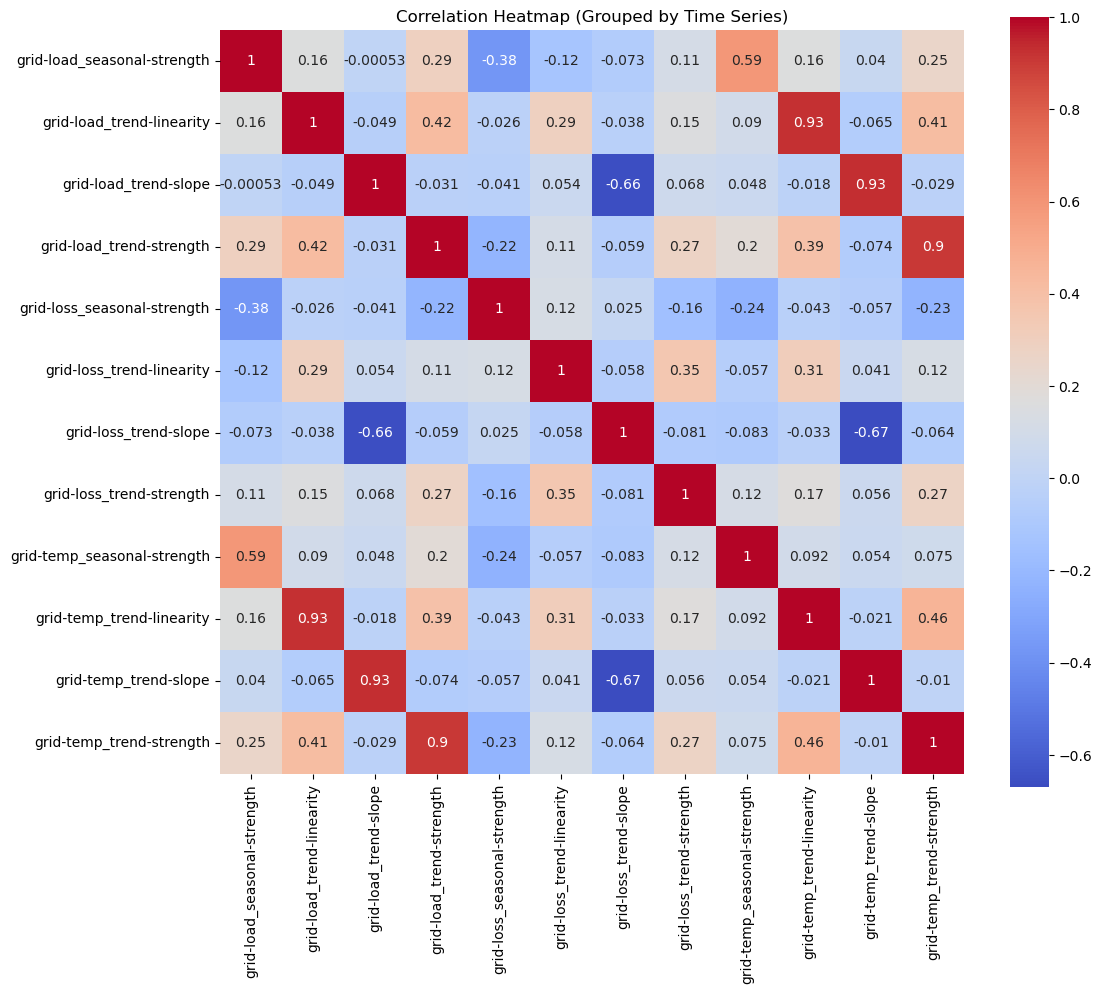

In [48]:
import seaborn as sns
import matplotlib.pyplot as plt

# Pivot and flatten column names
df_pivot = df.pivot_table(
    index='index',
    columns='ts_name',
    values=['trend-strength', 'trend-slope', 'trend-linearity', 'seasonal-strength']
)

# Flatten multi-index columns
df_pivot.columns = [f"{ts}_{feature}" for feature, ts in df_pivot.columns]

# Rearrange columns to group by ts_name first
sorted_columns = sorted(df_pivot.columns, key=lambda x: x.split('_')[0])
df_pivot = df_pivot[sorted_columns]

# Compute correlations
corr_matrix = df_pivot.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', square=True)
plt.title("Correlation Heatmap (Grouped by Time Series)")
plt.show()


In [49]:
df_pivot

,grid-load_seasonal-strength,grid-load_trend-linearity,grid-load_trend-slope,grid-load_trend-strength,grid-loss_seasonal-strength,grid-loss_trend-linearity,grid-loss_trend-slope,grid-loss_trend-strength,grid-temp_seasonal-strength,grid-temp_trend-linearity,grid-temp_trend-slope,grid-temp_trend-strength
index,,,,,,,,,,,,
0,0.944772,0.185495,-0.000562,0.862437,0.375897,0.140500,0.000073,0.945474,0.933000,0.194250,-0.001031,0.849588
1,0.968701,0.010127,-0.000091,0.860362,0.399718,0.065147,-0.000030,0.890130,0.964025,0.004129,-0.000102,0.854100
2,0.956525,0.348781,-0.000706,0.863940,0.295423,0.013555,0.000012,0.822561,0.950966,0.329179,-0.001179,0.856937
3,0.974909,0.719954,-0.001013,0.913748,0.183332,0.097971,-0.000051,0.905197,0.973655,0.717535,-0.001741,0.915380
4,0.952880,0.000430,0.000032,0.907825,0.257248,0.409159,-0.000144,0.944452,0.949127,0.002037,0.000123,0.910843
...,...,...,...,...,...,...,...,...,...,...,...,...
719,0.952433,0.140809,-0.000409,0.844201,0.674385,0.017933,-0.000020,0.959008,0.951429,0.161915,-0.000766,0.851451
720,0.960011,0.044459,0.000208,0.835426,0.736767,0.788320,-0.000117,0.960220,0.958886,0.045828,0.000361,0.837939
721,0.952221,0.718749,0.000863,0.814713,0.760612,0.940535,-0.000148,0.975278,0.950667,0.735319,0.001500,0.819299


# Loading correlation model

# Training correlation model

# Evaluating correlation model on test data